In [22]:
import sys
import os

# Add root project directory to path if needed, since in notebook directory
if not any([path.endswith('./../') for path in sys.path]):
    sys.path.insert(0, os.path.join(os.getcwd(), './../'))    

import requests
import io
import os
import s3fs
import glob

import dask.dataframe as dd
import pandas as pd
import numpy as np

from dask import delayed
from distributed import Client
from distributed import progress, wait

from core.data_acquisition import TaxiData

clean_df = TaxiData.clean_df

# S3 File system
fs = s3fs.S3FileSystem()

# Connection to the dask scheduler
client = Client('tcp://ec2-52-201-255-50.compute-1.amazonaws.com:8786')
client.restart()
client

Client Scheduler: tcp://ec2-52-201-255-50.compute-1.amazonaws.com:8786 Dashboard: http://ec2-52-201-255-50.compute-1.amazonaws.com:8787,Cluster Workers: 8 Cores: 64 Memory: 269.92 GB


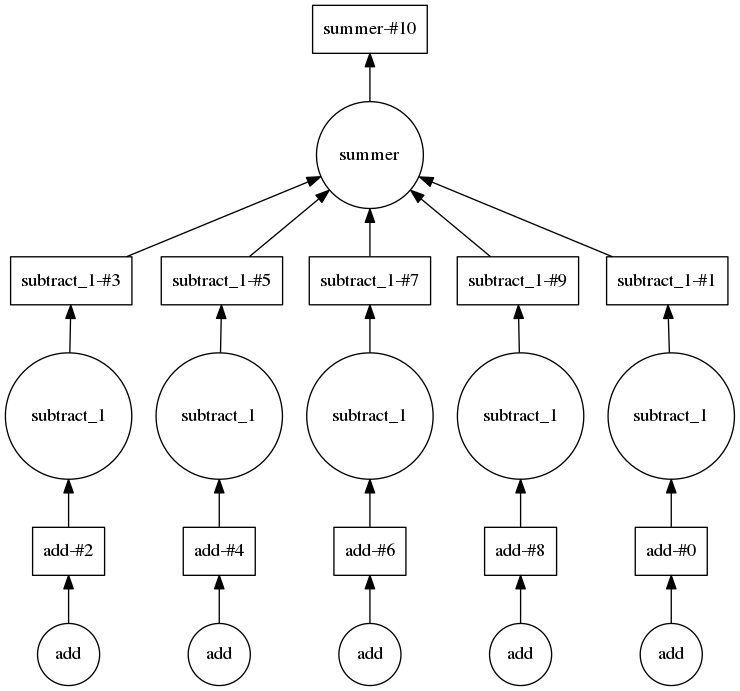

In [18]:
import time
import random

def add(x, y):
    time.sleep(random.random())
    return x + y

def subtract_1(x):
    time.sleep(random.random())
    return x - 1

def summer(arr):
    time.sleep(random.random())
    return sum(arr)
    
sub_results = []
for i in range(5):
    
    add_result = delayed(add)(i, i*2)
    subtract_result = delayed(subtract_1)(add_result)
    sub_results.append(subtract_result)
    
total = delayed(summer)(sub_results)
    
total.visualize()

In [17]:
total.compute()

25

In [3]:
import sys
counts = []

# Loop through years 2009-2017
for year in np.arange(2009, 2018):
    
    # Get only files pertaining to this year
    files = [f for f in fs.ls('nyc-tlc/trip data/') if str(year) in f and 'yellow' in f]
    
    # Process files in parallel. (client is asynchronous)
    for i, file in enumerate(files):
        
        # Extract year and month from filename
        _year, month = file[-11:-4].split('-')
        
        # Process data for current year and month
        df = dd.read_csv('s3://' + file, 
                         dtype='object',
                         error_bad_lines=False,
                         blocksize=int(128e6))
        df = df.map_partitions(clean_df)
        df = client.persist(df)
        
        # Yearly dataframe merging
        main_df = df if not i else main_df.append(df)
    
    # Write year's df to S3
    main_df.to_csv('s3://milesg-taxi-data-east/yellow-{year}-*.csv.gz'.format(year=year), compression='gzip')
    counts.append(main_df.passenger_count.count().compute())
    sys.stdout.write('\rYear: {} - Total {}'.format(_year, sum(counts)))
    
    # Clear from cluster memory
    client.cancel(main_df)


Year: 2017 - Total 1204768604

In [24]:
client.restart()

Client Scheduler: tcp://ec2-52-201-255-50.compute-1.amazonaws.com:8786 Dashboard: http://ec2-52-201-255-50.compute-1.amazonaws.com:8787,Cluster Workers: 8 Cores: 64 Memory: 269.92 GB


In [5]:
client.shutdown()